**This notebook demonstrates the performance of an LSTM model in predicting discharge. It is divided into two sections:**

1) Single Basin Prediction: Using an LSTM model to predict discharge for one basin.

2) Transfer Learning: Applying the model to predict discharge in a different basin.



The key question is: Can a model trained on one basin accurately predict discharge in another basin?

I started by downloading the CAMELS dataset from [here](https://gdex.ucar.edu/dataset/camels.html), which includes different types of hydrological data, such as attribute, geographical, and discharge data. The data came in a ZIP file, which I saved to my local machine. After downloading, I placed the ZIP file in the appropriate folder to ensure all my scripts and functions could access it. I created a specific folder for the project, making it easier to find and load the data. Then, I extracted the contents of the ZIP file, which included several subfolders with different data files like CSV and text files. Additionally, I have Python scripts with functions, notebooks for analysis, and the necessary libraries saved in the packages.py file. If the folders and files are arranged in the correct order, the notebooks will run just fine.

This is optional but you can create a conda environment by using the environment.yml file located in the binder/ directory. If you have a GPU available, make sure to install the GPU version of PyTorch.

Once the environment is set up, launch Jupyter Notebook or Jupyter Lab. In the first code cell, ensure you update the CAMELS_PATH to reflect the path where you’ve saved the CAMELS dataset on your local machine.





The paper [LSTM for Rainfall-Runoff Prediction](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C13&q=%22Rainfall%E2%80%93runoff+modelling+using+Long+Short-Term+Memory+%28LSTM%29+networks%22&btnG=) saved as good instructions for choosing an LSTM model.

In [1]:
import sys
from pathlib import Path
#------------ Define the path to the folder containing your scripts
scripts_path = Path("/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/scripts").resolve()
#------------ Add this path to sys.path if it's not already included
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))
    
from train import*
from data_processing import*
from model import Model
from data_loader import*
from packages import*

In [2]:
#pip install shap

In [3]:
pwd 

'/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/notebooks/single_basin'

# 1)  Predicting a Single Basin

In [4]:
# ---------------------------
# Configuration Parameters
# ---------------------------
basin = '01022500'            # 8-digit basin ID from the CAMELS dataset (modifiable)
hidden_size = 10              # Number of LSTM cells in the model
dropout_rate = 0.0            # Dropout rate for the final fully connected layer (0.0 to 1.0)
learning_rate = 1e-3          # Learning rate for the optimizer
sequence_length = 365         # Length (in days) of the meteorological record for each sample

# ---------------------------
# Dataset Setup
# ---------------------------
# Define date ranges for each dataset partition

# Training Data: from October 1, 1980 to September 30, 1995.
train_start_date = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
train_end_date = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
ds_train = CamelsTXT(basin, seq_length=sequence_length, period="train", dates=[train_start_date, train_end_date])
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)

# For evaluation datasets,use the training means and standard deviations for normalization.
means = ds_train.get_means()
stds = ds_train.get_stds()

# Validation Data: from October 1, 1995 to September 30, 2000. Any period can be choosen here.
val_start_date = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
val_end_date = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
ds_val = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[val_start_date, val_end_date],
                   means=means, stds=stds)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)

# Test Data: from October 1, 2000 to Septeber 30, 2010.
test_start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
test_end_date = pd.to_datetime("2010-09-30", format="%Y-%m-%d")
ds_test = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[test_start_date, test_end_date],
                    means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)

In [5]:
# ---------------------------
# Model, Optimizer, and Loss Setup
# ---------------------------
# Initialize the LSTM model with the specified parameters and move it to the appropriate device.
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)

# Setup the optimizer(Adam) fortraining the model.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Mean Squared Error.
loss_func = nn.MSELoss()

# ---------------------------
# Summary and Debug Information
# ---------------------------
print("Configuration:")
print(f" Basin ID: {basin}")
print(f" Sequence length: {sequence_length}")
print(f" Hidden size: {hidden_size}")
print(f" Dropout rate: {dropout_rate}")
print(f" Learning rate: {learning_rate}")
print(f" Training period: {train_start_date.date()} to {train_end_date.date()}")
print(f" Validation period: {val_start_date.date()} to {val_end_date.date()}")
print(f" Test period: {test_start_date.date()} to {test_end_date.date()}")
print("\nModel summary:")
print(model)

Configuration:
 Basin ID: 01022500
 Sequence length: 365
 Hidden size: 10
 Dropout rate: 0.0
 Learning rate: 0.001
 Training period: 1980-10-01 to 1995-09-30
 Validation period: 1995-10-01 to 2000-09-30
 Test period: 2000-10-01 to 2010-09-30

Model summary:
Model(
  (lstm): LSTM(5, 10, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [6]:
# Number of epochs
n_epochs = 20

# Lists to store metrics for each epoch
train_loss_list = []
val_loss_list = []
val_nse_list = []

for epoch in range(n_epochs):
    # ---------------------------
    # Training Phase
    # ---------------------------
    model.train()
    running_train_loss = 0.0
    for xs, ys in tr_loader:
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        optimizer.zero_grad()
        predictions = model(xs)
        loss = loss_func(predictions, ys)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xs.size(0)
    epoch_train_loss = running_train_loss / len(ds_train)
    train_loss_list.append(epoch_train_loss)
    
    # ---------------------------
    # Validation Phase (Loss)
    # ---------------------------
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xs, ys in val_loader:
            xs, ys = xs.to(DEVICE), ys.to(DEVICE)
            predictions = model(xs)
            loss = loss_func(predictions, ys)
            running_val_loss += loss.item() * xs.size(0)
    epoch_val_loss = running_val_loss / len(ds_val)
    val_loss_list.append(epoch_val_loss)
    
    # ---------------------------
    # Validation Phase (NSE)
    # ---------------------------
    # Evaluate on the validation set using the eval_model function
    obs, preds = eval_model(model, val_loader)
    preds = ds_val.local_rescale(preds.numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    val_nse_list.append(nse)
    
    # Print epoch metrics
    tqdm.tqdm.write(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {epoch_train_loss:.4f} - Validation NSE: {nse:.2f}")

Epoch 1/20 - Train Loss: 1.0091 - Validation NSE: 0.04
Epoch 2/20 - Train Loss: 0.9547 - Validation NSE: 0.10
Epoch 3/20 - Train Loss: 0.8964 - Validation NSE: 0.16
Epoch 4/20 - Train Loss: 0.8292 - Validation NSE: 0.23
Epoch 5/20 - Train Loss: 0.7479 - Validation NSE: 0.30
Epoch 6/20 - Train Loss: 0.6571 - Validation NSE: 0.40
Epoch 7/20 - Train Loss: 0.5646 - Validation NSE: 0.48
Epoch 8/20 - Train Loss: 0.5078 - Validation NSE: 0.52
Epoch 9/20 - Train Loss: 0.4691 - Validation NSE: 0.55
Epoch 10/20 - Train Loss: 0.4405 - Validation NSE: 0.57
Epoch 11/20 - Train Loss: 0.4152 - Validation NSE: 0.59
Epoch 12/20 - Train Loss: 0.3970 - Validation NSE: 0.60
Epoch 13/20 - Train Loss: 0.3810 - Validation NSE: 0.61
Epoch 14/20 - Train Loss: 0.3711 - Validation NSE: 0.62
Epoch 15/20 - Train Loss: 0.3567 - Validation NSE: 0.64
Epoch 16/20 - Train Loss: 0.3433 - Validation NSE: 0.63
Epoch 17/20 - Train Loss: 0.3323 - Validation NSE: 0.65
Epoch 18/20 - Train Loss: 0.3212 - Validation NSE: 0.65
E

In [7]:
model_path = "/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/notebooks/single_basin/saved_model"
# Define the full path for the saved model weights
model_save_path = model_path+"/model_weights.pth"
# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved as '{model_save_path}'.")

Model saved as '/Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/notebooks/single_basin/saved_model/model_weights.pth'.


In [8]:
# The performance metric being checked here is NSE, MSE too

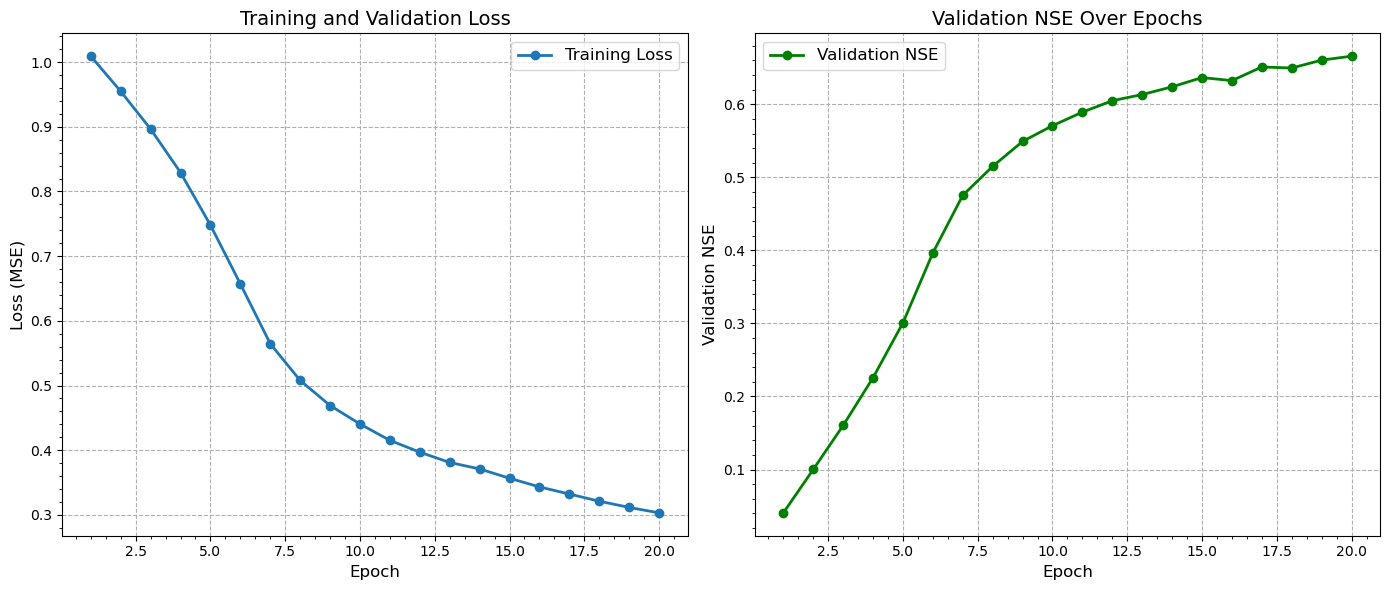

In [9]:
# Assuming epochs, train_loss_list, val_loss_list, and val_nse_list are defined:
epochs = range(1, n_epochs + 1)

# For a more clear observation of the figure, two subplots side by side
plt.figure(figsize=(14, 6))

# ---------------------------
# Training and Validation Loss
# ---------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label="Training Loss", marker='o', linewidth=2)
# plt.plot(epochs, val_loss_list, label="Validation Loss", marker='o', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--')
plt.minorticks_on()

# ---------------------------
# Validation NSE
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, val_nse_list, label="Validation NSE", marker='o', linewidth=2, color='green')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation NSE", fontsize=12)
plt.title("Validation NSE Over Epochs", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--')
plt.minorticks_on()
plt.tight_layout()
plt.show()


These plots show that as training progresses, the model's average error (MSE) decreases – meaning its predictions get closer to the actual discharge values.
Meanwhile, the NSE (Nash–Sutcliffe Efficiency) increases toward 1, which indicates that the model is performing much better than simply using the mean discharge as a prediction.


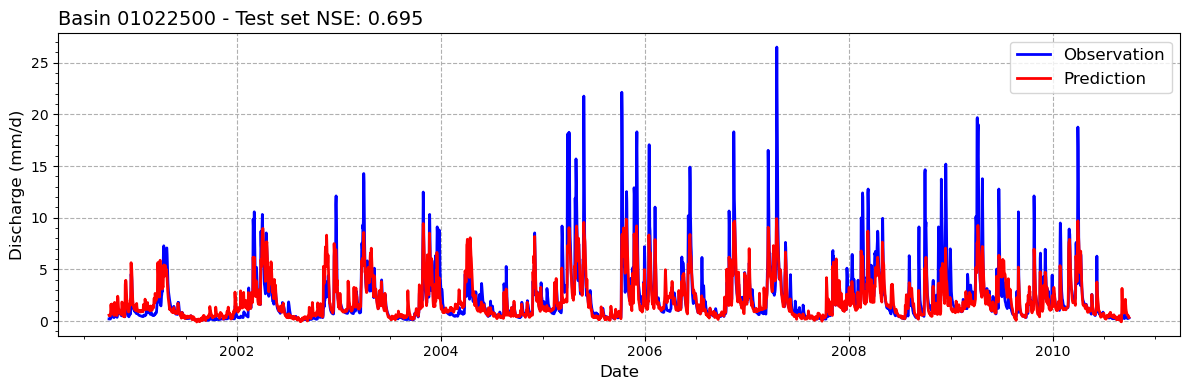

In [10]:
# Evaluate the model on the test set
obs, preds = eval_model(model, test_loader)
preds = ds_val.local_rescale(preds.numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)

# Create a date range for plotting based on the test set dates
start_date = ds_test.dates[0]
end_date = ds_test.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)

# Generate a standard time series plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(date_range, obs, label="Observation", lw=2, color="blue")
ax.plot(date_range, preds, label="Prediction", lw=2, color="red")
ax.set_title(f"Basin {basin} - Test set NSE: {nse:.3f}", fontsize=14, loc = "left")
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Discharge (mm/d)", fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='x')
ax.minorticks_on()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

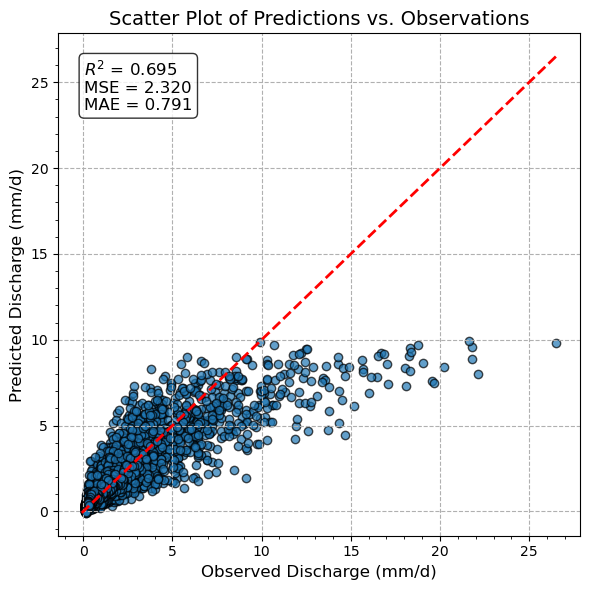

In [11]:
# --- Scatter Plot of Predictions vs. Observations ---
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate metrics
r2 = r2_score(obs, preds)
mse = mean_squared_error(obs, preds)
mae = mean_absolute_error(obs, preds)

# --- Figure 2: Scatter Plot of Predictions vs. Observations ---
fig2, ax2 = plt.subplots(figsize=(6, 6))
ax2.scatter(obs, preds, alpha=0.7, edgecolor='k')

# Plot a 1:1 line for reference
min_val = np.min([obs.min(), preds.min()])
max_val = np.max([obs.max(), preds.max()])
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# Set axis labels and title
ax2.set_xlabel("Observed Discharge (mm/d)", fontsize=12)
ax2.set_ylabel("Predicted Discharge (mm/d)", fontsize=12)
ax2.set_title("Scatter Plot of Predictions vs. Observations", fontsize=14)
ax2.minorticks_on()
ax2.grid()

# Annotate the plot with metrics inside the plot area
metrics_text = f"$R^2$ = {r2:.3f}\nMSE = {mse:.3f}\nMAE = {mae:.3f}"
ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig2.tight_layout()
plt.grid(True, linestyle='--')
plt.show()


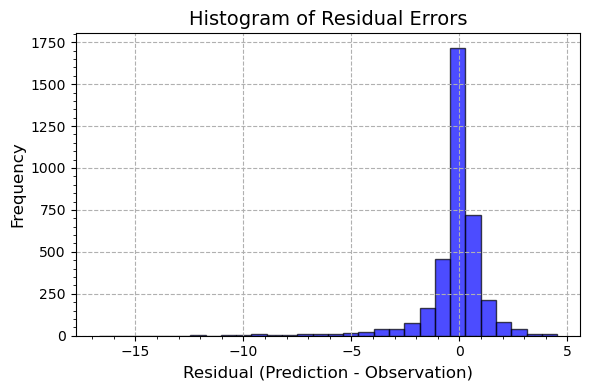

In [12]:
# --- Histogram of Residual Errors ---
residuals = preds - obs
fig3, ax3 = plt.subplots(figsize=(6, 4))
ax3.hist(residuals, bins=30, color='blue', edgecolor='k', alpha=0.7)
ax3.set_xlabel("Residual (Prediction - Observation)", fontsize=12)
ax3.set_ylabel("Frequency", fontsize=12)
ax3.set_title("Histogram of Residual Errors", fontsize=14)
ax3.minorticks_on()
fig3.tight_layout()
plt.grid(True, linestyle='--')
plt.show()

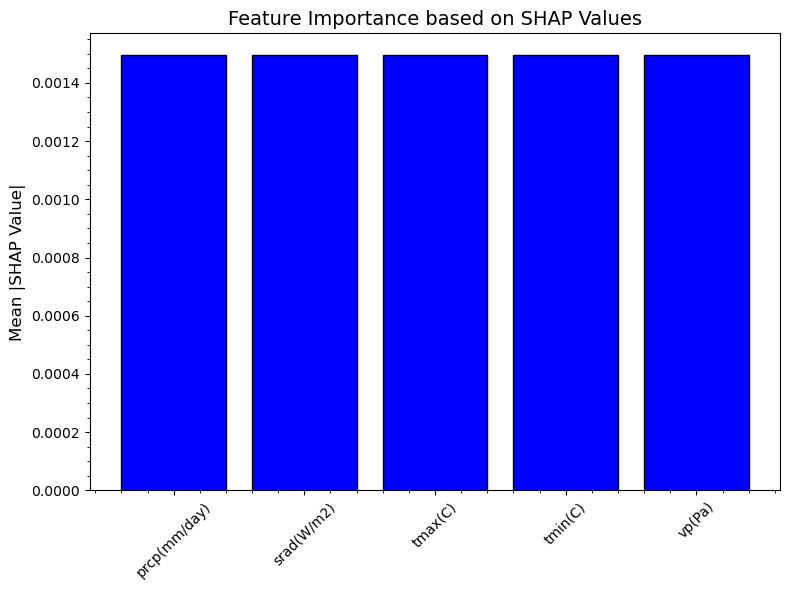

In [13]:
# ------------------------------
# SHAP Explanation for the Model
# ------------------------------

# Select a subset of training samples as the background for SHAP.
# ds_train.x is assumed to be a torch.Tensor of shape (N, sequence_length, features)
background = ds_train.x[:50].to(DEVICE)#still changing sample size and observing it is taking much time on my local computer

# Select some test samples for explanation (e.g., first 50 samples)
X_test = ds_test.x[:100].to(DEVICE)

# Create a DeepExplainer using the background samples.
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the test samples.
# Set check_additivity=False to bypass the additivity check.
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Extract the array from the list. The shape is (n_samples, sequence_length, n_features).
shap_vals = shap_values[0]
if isinstance(shap_vals, torch.Tensor):
    shap_vals = shap_vals.detach().cpu().numpy()

# Aggregate SHAP values over the time (sequence) dimension:
# Average the absolute SHAP values over the sequence length for each feature.
abs_shap = np.abs(shap_vals).mean(axis=1)  # Shape: (n_samples, n_features)
# Then average over all samples to get one value per feature.
mean_shap_per_feature = abs_shap.mean(axis=0)  # Shape: (n_features,)

# Define feature names corresponding to your input features.
feature_names = ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'tmin(C)', 'vp(Pa)']

# ------------------------------
# Plot the SHAP Feature Importances
# ------------------------------
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(feature_names, mean_shap_per_feature, color='blue', edgecolor='k')
ax.set_ylabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance based on SHAP Values', fontsize=14)
ax.minorticks_on()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2) Performing Transfer Learning on Another Basin

Transfer learning is a machine learning approach where a model trained on one dataset is adapted for use on a related dataset. In our work, we first trained an LSTM model to predict discharge for a single basin. We then use that pre-trained LSTM as a starting point to predict discharge for another basin, allowing the model to leverage previously learned features and patterns, which can improve performance even with limited data on the new basin.

We are using transfer learning in our work because we want to see how effective a model is when it’s applied to another basin selected from the same dataset. Initially, we trained an LSTM model to predict discharge for one basin. After that, we use this pre-trained model as a starting point to predict discharge for a different basin. This approach allows the model to leverage the patterns and features it learned from the first basin, which can improve performance, especially when there’s limited data available for the new basin.

The main reason we’re doing transfer learning is to test how well the model generalizes across different basins that share similar hydrological patterns. We want to see if the model can effectively transfer its knowledge from the first basin to the second, even when the data for the second basin is limited. This way, we can evaluate the model’s ability to handle different basins and assess how robust it is in predicting discharge for new, related data.

In [14]:
# ---------------------------
# Load the Pretrained Model
# ---------------------------
# Create a new model instance with the same architecture and load the saved weights.
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)

model.load_state_dict(torch.load(model_save_path))
model.eval()
print(f"Pretrained model loaded from {model_save_path}")

Pretrained model loaded from /Users/mpgrad/Desktop/TapiwaComp_Exam/Artifact/Computing_Artifact/notebooks/single_basin/saved_model/model_weights.pth


Transfer Learning: New Basin 13310700 - NSE: -0.528


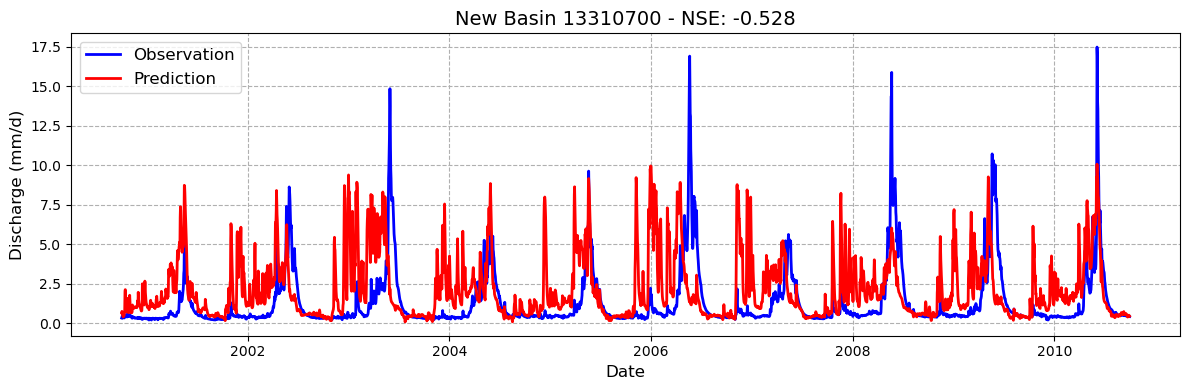

In [15]:
# ---------------------------
# New Basin Dataset for Transfer Learning
# ---------------------------
# Define the new basin ID and date range for prediction (adjust as needed).
new_basin = '13310700'  # New basin id picked for transfer learning
new_start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
new_end_date = pd.to_datetime("2010-09-30", format="%Y-%m-%d")

# For transfer, you can choose to use the normalization parameters (means/stds) from the original basin,
# or recalculate them using training data from the new basin.
# Here we use the same means and stds from the original training set.
new_ds = CamelsTXT(new_basin, seq_length=sequence_length, period="eval",
                   dates=[new_start_date, new_end_date], means=means, stds=stds)
new_loader = DataLoader(new_ds, batch_size=2048, shuffle=False)

# ---------------------------
# Evaluate the Model on the New Basin
# ---------------------------
# Get predictions using the pretrained model.
obs_new, preds_new = eval_model(model, new_loader)
# Rescale predictions to the original discharge units.
preds_new = new_ds.local_rescale(preds_new.numpy(), variable='output')
obs_new = obs_new.numpy()
nse_new = calc_nse(obs_new, preds_new)
print(f"Transfer Learning: New Basin {new_basin} - NSE: {nse_new:.3f}")

# ---------------------------
# Plot Predictions for the New Basin
# ---------------------------
# Create a date range for plotting.
start_date = new_ds.dates[0]
end_date = new_ds.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)

plt.figure(figsize=(12, 4))
plt.plot(date_range, obs_new, label="Observation", lw=2, color="blue")
plt.plot(date_range, preds_new, label="Prediction", lw=2, color="red")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Discharge (mm/d)", fontsize=12)
plt.title(f"New Basin {new_basin} - NSE: {nse_new:.3f}", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--")
plt.xticks()
plt.tight_layout()
plt.show()


The model did not perform as good on the second basin as the first.

 In this chart, the observed discharge often has sharp peaks that the predicted discharge fails to capture. Because the model consistently underestimates these higher flows, its Nash–Sutcliffe Efficiency (NSE) is negative (–0.528), this means thatit’s doing worse than if we simply predicted the average discharge every day. Essentially, the model didn’t learn the unique patterns of this new basin well, so its predictions fall short whenever there are spikes in the observed flow.

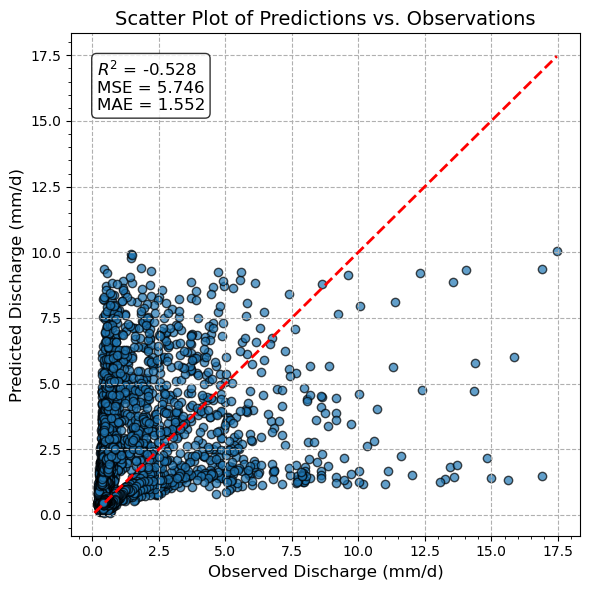

In [16]:
# Calculate metrics
r2 = r2_score(obs_new, preds_new)
mse = mean_squared_error(obs_new, preds_new)
mae = mean_absolute_error(obs_new, preds_new)

# --- Figure 2: Scatter Plot of Predictions vs. Observations ---
fig2, ax2 = plt.subplots(figsize=(6, 6))
ax2.scatter(obs_new, preds_new, alpha=0.7, edgecolor='k')

# Plot a 1:1 line for reference
min_val = np.min([obs_new.min(), preds_new.min()])
max_val = np.max([obs_new.max(), preds_new.max()])
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

# Set axis labels and title
ax2.set_xlabel("Observed Discharge (mm/d)", fontsize=12)
ax2.set_ylabel("Predicted Discharge (mm/d)", fontsize=12)
ax2.set_title("Scatter Plot of Predictions vs. Observations", fontsize=14)
ax2.minorticks_on()
ax2.grid()

# Annotate the plot with metrics inside the plot area
metrics_text = f"$R^2$ = {r2:.3f}\nMSE = {mse:.3f}\nMAE = {mae:.3f}"
ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig2.tight_layout()
plt.grid(True, linestyle='--')
plt.show()